<font color='blue'> **Zahasky_08_________________d_________________ from 10___RMG_1_PyGSLIB** </font> 

In [1]:
import flopy; import sys; import os; import time; import numpy as np; import matplotlib.pyplot as plt        ; from pathlib import Path ; import pandas as pd
EXF='E:\\15_REPOS\\00_BETAMI\\bin\\MF2005.exe' ; EXT='E:\\15_REPOS\\00_BETAMI\\bin\\mt3d-usgs_1.1.0_64.exe'  ; _R=Path("_R"); _R.mkdir(exist_ok=True)       ; import gstools as gs  
TA=Path("_R/_08d"); TA.mkdir(exist_ok=True)    ; REF1= ('E:/15_REPOS/02_Beta-Me/data/Madison')               ; D1=os.path.join(REF1,'A_sig100.csv');D2=os.path.join(REF1,'output.csv')
import geostatspy.geostats as geostats         ; sys.path.append('E:/15_REPOS/02_Beta-Me/data/Krig/BibliOS') ; from geostats import backtr     #backtr? 

nn: (20, 40)


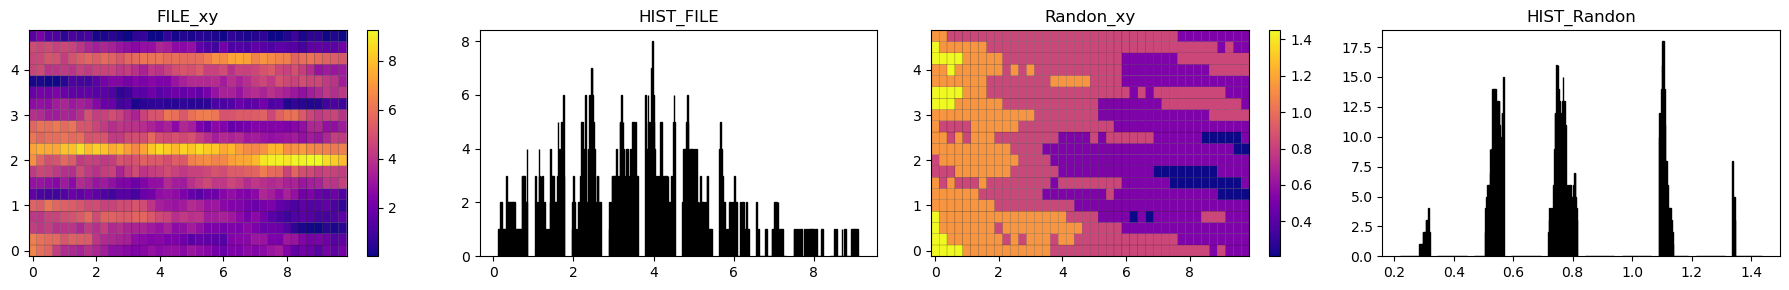

In [2]:
NO= np.loadtxt(D2,delimiter=',')      ;nrow= 20 ;ncol= 40     ; HIS1=NO.reshape(1,nrow,ncol)   ; HK1=HIS1        ; R=nrow;C=ncol ; FIG1=HIS1[0,:,:]  ; F1=HIS1.reshape(R,C)
XX = range(nrow);ZZ=range(ncol)                                                                  
M1 = gs.Exponential(dim=2, var=200, len_scale=[1000, 500, .01],nugget=0.05  ,angles=np.pi / 2)        ; srf=gs.SRF(M1)  ; nn=srf.structured([XX, ZZ]) ;print('nn:',nn.shape)
VA1=np.linspace(np.min(srf.field),np.max(srf.field),5); FIG2  =srf.transform("discrete",store="f1",values=VA1)   ; FIG2=abs(FIG2)/10    ; F2=FIG2.reshape(R,C)  ; HK2=FIG2.reshape(1,20,40)

import warnings ; from matplotlib import MatplotlibDeprecationWarning ; warnings.filterwarnings('ignore', category=MatplotlibDeprecationWarning)    

fig = plt.figure(figsize=(18, 3))                   ;G25=[0.25,0.25] ;Lx=(ncol-1)*G25[1];Ly=(nrow-1)*G25[0]      ; y,x=np.mgrid[slice(0,Ly+G25[0],G25[0]),slice(0,Lx+G25[1],G25[1])]
ax=fig.add_subplot(141) ; plt.pcolor(x,y,FIG1 ,cmap='plasma' ,shading='auto',edgecolor='k',linewidth=0.1)  ; plt.colorbar()                        ;plt.title('FILE_xy')
ax=fig.add_subplot(142) ; plt.hist  (F1       ,edgecolor='black')   ; pd.DataFrame(HIS1.reshape(R,C)).to_csv(TA/"HIS1.csv") ;plt.title('HIST_FILE')  

ax=fig.add_subplot(143) ; plt.pcolor(x,y,FIG2 ,cmap='plasma' ,shading='auto',edgecolor='k',linewidth=0.1)  ; plt.colorbar()                        ;plt.title('Randon_xy') 
ax=fig.add_subplot(144) ; plt.hist  (F2       ,edgecolor='black') ;plt.title('HIST_Randon')  ; plt.tight_layout(); plt.show()

In [3]:
#print(HK1.shape)     ;DF = pd.DataFrame(NO) ; DF.columns=['KH']; DF.describe().transpose()         #pd.DataFrame(FIG2).to_numpy()

In [4]:
#DF = pd.DataFrame(FIG2.reshape(-1)); DF.columns=['KH']; DF.describe().transpose()  

<font color='blue'> **MODFLOW ______________________________________________________________________________________________________** </font> 

In [5]:
delv = 0.25  ;delr = 0.25 ;delc = 1  ; VV = 0.01 ;  TRPT =0.1 ; itype= -1 ; DISP = 0.01; DISP = 0.2                                       ; itmuni=1; lenuni=3 ;MTU='S';MTV='CM'
PERLEN_T = [60*3,60*58]        ; NPER_T = len(PERLEN_T)   ; NPRS = 100
PERLEN_F = [np.sum(PERLEN_T)]  ; NPER_F = len(PERLEN_F)   ; TIMPRS=np.linspace(0,np.sum(PERLEN_F), NPRS, endpoint = False)  ; print('PERLEN_T :',PERLEN_T, 'PERLEN_F :',PERLEN_F)

def model_2D(DIR, PERLEN_T, HK, VV, DISP, TRPT, itype):
    
    HK_size = HK.shape ;nlay=HK_size[0] ;nrow=HK_size[1] ; ncol=HK_size[2]         ; IB = np.ones((nlay, nrow, ncol) , dtype=int)        ; IB[0,:,0]=-1 ;IB[0,:,-1] = -1      
    K_MEAN=np.exp(np.sum(np.log(HK))/HK.size) ;RO=0.3 ;q=VV*RO ;Lx=(ncol-1)*delr   ; IC = np.zeros((nlay,nrow,ncol),dtype=float)         ; H1   = q*Lx/K_MEAN  ;IC[0,:,0]= H1
    IBC = np.ones((nlay, nrow, ncol) , dtype=int)                                  ; SCONC = np.zeros((nlay, nrow, ncol), dtype=float)   ; C_IN = [1.0, 0.0] 
    
    CTT = np.zeros((nrow, 5), dtype=float)
    for row in range(0, nrow):   CTT[row] = [0, row, 0, C_IN[0], itype]                           
    CW2 = CTT.copy()            ;CW2[:,3] =             C_IN[1]                    ; MTW_S = {0:CTT, 1:CW2}        ; MF=DIR+'_mf';MT=DIR+'_mt'  ;WS=os.path.join(TA,DIR)
    
    mf  = flopy.modflow.Modflow (modelname=MF, model_ws=WS, exe_name=EXF)
    dis = flopy.modflow.ModflowDis (mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=NPER_F, delr=delr, delc=delc, top=0., botm=[0 - delv],perlen=PERLEN_F, itmuni=itmuni, lenuni=lenuni)
    bas = flopy.modflow.ModflowBas (mf, ibound=IB, strt=IC)  ; lpf = flopy.modflow.ModflowLpf(mf, hk=HK, laytyp=0)
    pcg = flopy.modflow.ModflowPcg (mf) ;lmt = flopy.modflow.ModflowLmt(mf) ; oc = flopy.modflow.ModflowOc(mf)                               ;mf.write_input() ;mf.run_model(silent=True) 

    mt  = flopy.mt3d.Mt3dms  (modelname=MT, model_ws=WS, exe_name=EXT, modflowmodel=mf)            ;mixelm = -1 ;adv=flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm)
    btn = flopy.mt3d.Mt3dBtn (mt, icbund=IBC, prsity=RO, sconc=SCONC, tunit=MTU, lunit=MTV, nper=NPER_T, perlen=PERLEN_T, nprs=NPRS, timprs=TIMPRS ) 
    dsp = flopy.mt3d.Mt3dDsp (mt, al=DISP, trpt=TRPT)    ;ssm=flopy.mt3d.Mt3dSsm(mt,stress_period_data=MTW_S)   ;gcg=flopy.mt3d.Mt3dGcg(mt)  ;mt.write_input() ;mt.run_model(silent=True)

    if os.path.isfile(os.path.join(WS, 'MT3D001.UCN')):  os.remove(os.path.join(WS, 'MT3D001.UCN'))  
    mt.run_model(silent=True)
    
    hdobj  = flopy.utils.HeadFile(os.path.join(WS, MF+'.hds'))       ; HE1 = hdobj.get_data()               ; print("Inlet_H:"+str(H1) + "('Cm')") 
    ucnobj = flopy.utils.UcnFile(os.path.join(WS, 'MT3D001.UCN'))    ; TIMES = np.array(ucnobj.get_times())   ; CON1 = ucnobj.get_alldata()   ; return mf, mt, TIMES, CON1, HE1

DIR='ANI0'   ; mf,mt,TIMES,CON1,HE0 = model_2D(DIR, PERLEN_T, HK1, VV, DISP, TRPT, itype)      ; M0 = np.transpose(np.mean([CON1[:,0,:,-1]],axis=2))  ; TI0=TIMES
DIR='ANI1'   ; mf,mt,TIMES,CON2,HE1 = model_2D(DIR, PERLEN_T, HK2, VV, DISP, TRPT, itype)      ; M1 = np.transpose(np.mean([CON2[:,0,:,-1]],axis=2))  ; TI1=TIMES
#DIR='ANI2'  ; mf,mt,TIMES,CON3,HE2 = model_2D(DIR, PERLEN_T, HK2, VV, DISP, TRPT, itype)      ; M2 = np.transpose(np.mean([CON3[:,0,:,-1]],axis=2))  ; TI2=TIMES

PERLEN_T : [180, 3480] PERLEN_F : [3660]
Inlet_H:0.010337753991322533('Cm')
Inlet_H:0.039912508776754195('Cm')


In [6]:
CON1[:,0,:,-1].shape

(102, 20)

<font color='orange'> **RES_01 ________________________________________________________________________________________________________________________** </font>

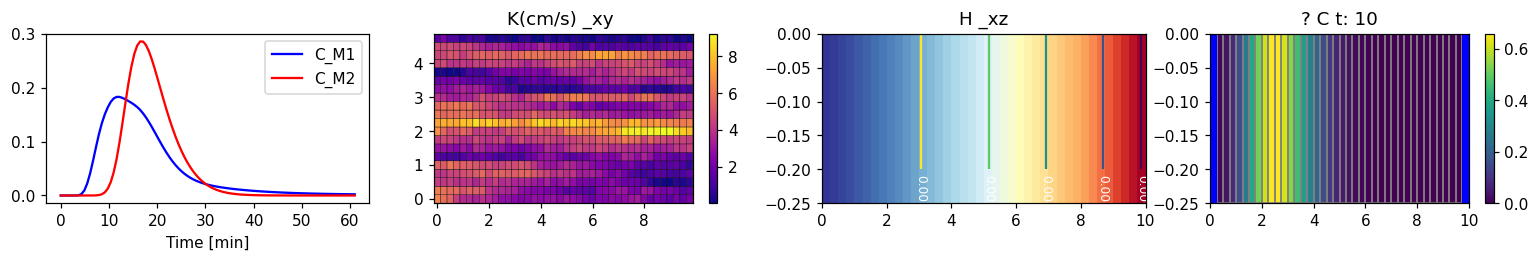

In [7]:
TT = 10 ; HH= HE0                                                                      ;VV1=np.min(HH[0]) ; VV2=np.max(HH[0])   ; LH=np.arange(VV1, VV2, VV2/5) ; T60=TIMES/60 ; LL={'Row':0}
fig = plt.figure(figsize=(22, 2), dpi=110)  
ax=fig.add_subplot(151) ;plt.xlabel('Time [min]') ; plt.plot(T60,M0,color='b',label='C_M1');plt.legend() ;plt.plot(T60,M1,color='r',label='C_M2') ;plt.legend()  #plt.plot(T60,M2,color='green',label='RUN2') 

ax=fig.add_subplot(152) ;plt.pcolor(x,y,FIG1 ,cmap='plasma',shading='auto',edgecolor='k')  ;plt.colorbar() ;plt.title('K(cm/s) _xy ') 
ax=fig.add_subplot(153);SU=flopy.plot.PlotCrossSection(model=mf,line=LL);UU=SU.contour_array(HH,levels=LH) ;plt.clabel(UU,colors='w',fontsize=8); HV=SU.plot_array(HH,head=HH,cmap='RdYlBu');plt.title("H _xz")#;plt.axis('off') 

ax=fig.add_subplot(154);SX=flopy.plot.PlotCrossSection(model=mf,line=LL);VK=SX.plot_array(CON1[TT]);SX.plot_grid();plt.colorbar(VK);SX.plot_ibound(head=HH) ;plt.title('? C t: %1.0f'%(TT))#;plt.axis('off') 

#ax=fig.add_subplot(155) ;plt.pcolor(x,y,HH ,cmap='plasma',shading='auto',edgecolor='k')  ;plt.colorbar() ;plt.title('K(cm/s) _xy ') 


#ax=fig.add_subplot(155);SX=flopy.plot.PlotCrossSection(model=mf,line=LL);VK=SX.plot_array(CON2[TT]);SX.plot_grid();plt.colorbar(VK)                         ;plt.title('planta? C t: %1.0f'%(TT))#;plt.axis('off') ; 
plt.show()

In [8]:
pd.DataFrame(CON1.reshape(CON1.shape[0],-1)).to_csv(TA/"_1_CON_all.csv")  ; pd.DataFrame(CON2.reshape(CON2.shape[0],-1)).to_csv(TA/"_2_CON_all.csv")
pd.DataFrame(CON1[-1,0,:,:]).to_csv (TA/"_3_CON.csv")  
pd.DataFrame(HE0[0,:,:])    .to_csv (TA/"_4_H_steady.csv")   ; pd.DataFrame(HK2.reshape(nrow, ncol)).to_csv (TA/"_5_anis_perm_field_.csv")  
pd.DataFrame(TIMES).to_csv (TA/"_6_TIMES.csv")               ; pd.DataFrame(np.cumsum(PERLEN_T)).to_csv(TA/"_7_Times_b.csv")

#print(CON2.shape) ; CON2[:,0,:,-1].shape  ; CON1.shape      ; #print(HE1.shape)  ; print(CON2.shape) ; pd.DataFrame(CON1[12,0,:,:]).to_csv(TA/'CONC_12.csv')